In [1]:
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon
import common_datasets.binary_classification as binclas
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('/home/gykovacs/appendicitis-reg.csv')

In [3]:
data.head()

,name,oversampler,sparam,classifier,cparam,auc
0,appendicitis,ADASYN,"{'d_th': 0.9, 'n_neighbors': 11, 'proportion':...",DecisionTreeClassifier,"{'max_depth': 1, 'random_state': 5}","[0.8529411764705882, 0.6029411764705881, 0.786..."
1,appendicitis,ADASYN,"{'d_th': 0.9, 'n_neighbors': 11, 'proportion':...",DecisionTreeClassifier,"{'max_depth': 11, 'random_state': 5}","[0.8117647058823529, 0.7279411764705881, 0.786..."
2,appendicitis,ADASYN,"{'d_th': 0.9, 'n_neighbors': 11, 'proportion':...",DecisionTreeClassifier,"{'max_depth': 13, 'random_state': 5}","[0.8117647058823529, 0.7279411764705881, 0.786..."
3,appendicitis,ADASYN,"{'d_th': 0.9, 'n_neighbors': 11, 'proportion':...",DecisionTreeClassifier,"{'max_depth': 15, 'random_state': 5}","[0.8117647058823529, 0.7279411764705881, 0.786..."
4,appendicitis,ADASYN,"{'d_th': 0.9, 'n_neighbors': 11, 'proportion':...",DecisionTreeClassifier,"{'max_depth': 17, 'random_state': 5}","[0.8117647058823529, 0.7279411764705881, 0.786..."


In [5]:
data['auc_mean'] = data['auc'].apply(lambda tmp: np.mean(eval(tmp)))
data['auc_median'] = data['auc'].apply(lambda tmp: np.median(eval(tmp)))
data['auc_std'] = data['auc'].apply(lambda tmp: np.std(eval(tmp)))

In [10]:
def extract_reg_param(row):
    if row['classifier'] == 'SVC':
        return eval(row['cparam'])['C']
    if row['classifier'] == 'DecisionTreeClassifier':
        return eval(row['cparam'])['max_depth']
    if row['classifier'] == 'RandomForestClassifier':
        return eval(row['cparam'])['max_depth']
    if row['classifier'] == 'KNeighborsClassifier':
        return eval(row['cparam'])['n_neighbors']

def extract_classifier_subparam(row):
    if row['classifier'] == 'SVC':
        kernel = eval(row['cparam']).get('kernel', 'rbf')
        degree = str(eval(row['cparam']).get('degree', ''))
        return kernel + degree
    return ''

In [12]:
data['reg_param'] = data.apply(extract_reg_param, axis=1)
data['kernel'] = data.apply(extract_classifier_subparam, axis=1)

In [119]:
filtered = data[data['classifier'] == 'RandomForestClassifier']
filtered = filtered[filtered['kernel'] == '']

In [120]:
def label_params(pdf):
    oversampler = pdf.iloc[0]['oversampler']
    pdf['param_label'] = [f'par_{oversampler}_{idx}' for idx in range(len(pdf))]
    return pdf

In [121]:
oversamplers = filtered[['oversampler', 'sparam']].drop_duplicates()
labels = oversamplers.groupby('oversampler').apply(label_params).reset_index(drop=True)
labeled = pd.merge(filtered, labels, on=['oversampler', 'sparam'])

baseline = labeled[labeled['oversampler'] == 'NoSMOTE'].sort_values('reg_param')
rest = labeled[labeled['oversampler'] != 'NoSMOTE']

In [122]:
for label in rest['param_label'].drop_duplicates().values:
    tmp = rest[rest['param_label'] == label]
    baseline = pd.merge(baseline, tmp[['reg_param', 'auc_mean']].rename(columns={'auc_mean': 'auc_mean' + '_' + label}))

In [123]:
to_plot = [col for col in baseline.columns if col.startswith('auc_mean')]

In [124]:
regs = []
aucs = []
for col in to_plot:
    maximum = baseline[col].max()
    reg = baseline[baseline[col] == maximum].iloc[0]['reg_param']
    regs.append(reg)
    aucs.append(maximum)

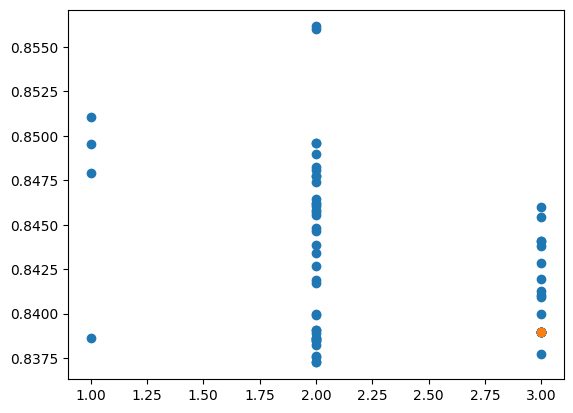

In [125]:
plt.scatter(regs, aucs)
plt.scatter(regs[:1], aucs[:1])

In [126]:
import matplotlib.pyplot as plt

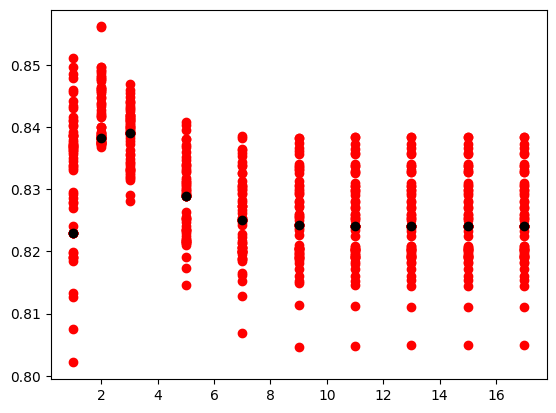

In [131]:
for col in reversed(to_plot):
    if col == 'auc_mean':
        plt.scatter(baseline['reg_param'], baseline[col], c='black')
    #elif 'SMOTE' in col and not 'Borderline' in col:
    #    plt.scatter(baseline['reg_param'], baseline[col], c='red')
    #elif 'SMOTE' in col and 'IPF' not in col and 'SMOTE1' not in col:
    #elif 'Borderline_SMOTE1' in col:
    else:
        plt.scatter(baseline['reg_param'], baseline[col], c='red')

In [68]:
data['oversampler'].drop_duplicates()

0                  ADASYN
444     Borderline_SMOTE1
1184                  Lee
1924              NoSMOTE
1998              ProWSyn
2738                SMOBD
3478                SMOTE
3848            SMOTE_IPF
Name: oversampler, dtype: object

In [31]:
labels

,oversampler,sparam,param_label
0,ADASYN,"{'d_th': 0.9, 'n_neighbors': 11, 'proportion':...",par_ADASYN_0
1,ADASYN,"{'d_th': 0.9, 'n_neighbors': 17, 'proportion':...",par_ADASYN_1
2,ADASYN,"{'d_th': 0.9, 'n_neighbors': 3, 'proportion': ...",par_ADASYN_2
3,ADASYN,"{'d_th': 0.9, 'n_neighbors': 5, 'proportion': ...",par_ADASYN_3
4,ADASYN,"{'d_th': 0.9, 'n_neighbors': 7, 'proportion': ...",par_ADASYN_4
...,...,...,...
57,SMOTE_IPF,"{'classifier': ['sklearn.tree', 'DecisionTreeC...",par_SMOTE_IPF_5
58,SMOTE_IPF,"{'classifier': ['sklearn.tree', 'DecisionTreeC...",par_SMOTE_IPF_6
59,SMOTE_IPF,"{'classifier': ['sklearn.tree', 'DecisionTreeC...",par_SMOTE_IPF_7
60,SMOTE_IPF,"{'classifier': ['sklearn.tree', 'DecisionTreeC...",par_SMOTE_IPF_8


In [29]:
rest

,name,oversampler,sparam,classifier,cparam,auc,auc_mean,auc_median,auc_std,reg_param,kernel,param_label_x,param_label_y,param_label
0,appendicitis,ADASYN,"{'d_th': 0.9, 'n_neighbors': 11, 'proportion':...",KNeighborsClassifier,"{'n_neighbors': 1, 'n_jobs': 1}","[0.7235294117647059, 0.5441176470588235, 0.727...",0.726110,0.727941,0.110724,1.0,,par_0,par_0,par_ADASYN_0
1,appendicitis,ADASYN,"{'d_th': 0.9, 'n_neighbors': 11, 'proportion':...",KNeighborsClassifier,"{'n_neighbors': 13, 'n_jobs': 1}","[0.9411764705882353, 0.6617647058823529, 0.794...",0.820941,0.838235,0.114988,13.0,,par_0,par_0,par_ADASYN_0
2,appendicitis,ADASYN,"{'d_th': 0.9, 'n_neighbors': 11, 'proportion':...",KNeighborsClassifier,"{'n_neighbors': 17, 'n_jobs': 1}","[0.9470588235294117, 0.6838235294117647, 0.845...",0.824679,0.845588,0.113866,17.0,,par_0,par_0,par_ADASYN_0
3,appendicitis,ADASYN,"{'d_th': 0.9, 'n_neighbors': 11, 'proportion':...",KNeighborsClassifier,"{'n_neighbors': 21, 'n_jobs': 1}","[0.9588235294117646, 0.6691176470588234, 0.852...",0.830891,0.852941,0.115643,21.0,,par_0,par_0,par_ADASYN_0
4,appendicitis,ADASYN,"{'d_th': 0.9, 'n_neighbors': 11, 'proportion':...",KNeighborsClassifier,"{'n_neighbors': 25, 'n_jobs': 1}","[0.9470588235294117, 0.6323529411764707, 0.852...",0.835340,0.860294,0.117825,25.0,,par_0,par_0,par_ADASYN_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,appendicitis,SMOTE_IPF,"{'classifier': ['sklearn.tree', 'DecisionTreeC...",KNeighborsClassifier,"{'n_neighbors': 57, 'n_jobs': 1}","[0.988235294117647, 0.625, 0.8602941176470589,...",0.856984,0.875735,0.106681,57.0,,par_9,par_9,par_SMOTE_IPF_9
1112,appendicitis,SMOTE_IPF,"{'classifier': ['sklearn.tree', 'DecisionTreeC...",KNeighborsClassifier,"{'n_neighbors': 61, 'n_jobs': 1}","[0.9941176470588234, 0.6397058823529411, 0.830...",0.852424,0.867647,0.107602,61.0,,par_9,par_9,par_SMOTE_IPF_9
1113,appendicitis,SMOTE_IPF,"{'classifier': ['sklearn.tree', 'DecisionTreeC...",KNeighborsClassifier,"{'n_neighbors': 65, 'n_jobs': 1}","[0.988235294117647, 0.625, 0.8602941176470588,...",0.851985,0.867647,0.107736,65.0,,par_9,par_9,par_SMOTE_IPF_9
1114,appendicitis,SMOTE_IPF,"{'classifier': ['sklearn.tree', 'DecisionTreeC...",KNeighborsClassifier,"{'n_neighbors': 69, 'n_jobs': 1}","[0.9941176470588234, 0.6544117647058824, 0.867...",0.854440,0.867647,0.105316,69.0,,par_9,par_9,par_SMOTE_IPF_9


,oversampler,sparam,param_label
0,ADASYN,"{'d_th': 0.9, 'n_neighbors': 11, 'proportion':...",par_0
1,ADASYN,"{'d_th': 0.9, 'n_neighbors': 17, 'proportion':...",par_1
2,ADASYN,"{'d_th': 0.9, 'n_neighbors': 3, 'proportion': ...",par_2
3,ADASYN,"{'d_th': 0.9, 'n_neighbors': 5, 'proportion': ...",par_3
4,ADASYN,"{'d_th': 0.9, 'n_neighbors': 7, 'proportion': ...",par_4
...,...,...,...
57,SMOTE_IPF,"{'classifier': ['sklearn.tree', 'DecisionTreeC...",par_5
58,SMOTE_IPF,"{'classifier': ['sklearn.tree', 'DecisionTreeC...",par_6
59,SMOTE_IPF,"{'classifier': ['sklearn.tree', 'DecisionTreeC...",par_7
60,SMOTE_IPF,"{'classifier': ['sklearn.tree', 'DecisionTreeC...",par_8


In [17]:
len(oversamplers)

62

In [52]:
def extract_reg_param(row):
    if row['classifier'] == 'SVC':
        return eval(row['cparam'])['C']
    if row['classifier'] == 'DecisionTreeClassifier':
        return eval(row['cparam'])['max_depth']
    if row['classifier'] == 'RandomForestClassifier':
        return eval(row['cparam'])['max_depth']
    if row['classifier'] == 'KNeighborsClassifier':
        return eval(row['cparam'])['n_neighbors']

def extract_classifier_subparam(row):
    if row['classifier'] == 'SVC':
        kernel = eval(row['cparam']).get('kernel', 'rbf')
        degree = str(eval(row['cparam']).get('degree', ''))
        return kernel + degree
    return ''

In [53]:
grouped['reg_param'] = grouped.apply(extract_reg_param, axis=1)

In [54]:
for classifier in ['SVC', 'DecisionTreeClassifier', 'RandomForestClassifier', 'KNeighborsClassifier']:
    filtered = grouped[grouped['classifier'] == classifier]
    nosmote = filtered[filtered['oversampler'] == 'NoSMOTE']
    smote = filtered[filtered['oversampler'] == 'SMOTE']
    merged = pd.merge(nosmote,
                        smote[['reg_param', 'cparam', 'auc_mean']].rename(columns={'auc_mean': 'auc_mean_smote'}),
                        on=['reg_param', 'cparam'])
    merged['kernel'] = merged.apply(extract_classifier_subparam, axis=1)

    kernels = merged['kernel'].drop_duplicates().values

    for kernel in kernels:
        print(merged[merged['kernel'] == kernel].sort_values('reg_param')[['classifier', 'kernel', 'reg_param', 'auc_mean', 'auc_mean_smote']])

   classifier kernel  reg_param  auc_mean  auc_mean_smote
0         SVC  poly2      0.001  0.711359        0.250122
3         SVC  poly2      0.002  0.713850        0.250703
6         SVC  poly2      0.005  0.713638        0.261456
9         SVC  poly2      0.010  0.710585        0.657913
12        SVC  poly2      0.020  0.710629        0.746131
15        SVC  poly2      0.050  0.710712        0.750371
18        SVC  poly2      0.100  0.713918        0.751929
21        SVC  poly2      0.200  0.723368        0.752891
24        SVC  poly2      0.500  0.725665        0.755069
27        SVC  poly2      1.000  0.720097        0.755713
30        SVC  poly2      2.000  0.718424        0.746403
   classifier kernel  reg_param  auc_mean  auc_mean_smote
1         SVC  poly3      0.001  0.821631        0.155966
4         SVC  poly3      0.002  0.821949        0.402381
7         SVC  poly3      0.005  0.820960        0.857509
10        SVC  poly3      0.010  0.820712        0.848819
13        SVC 

In [55]:
merged[merged['kernel'] == ''].sort_values('reg_param')[['classifier', 'reg_param', 'auc_mean', 'auc_mean_smote']]

,classifier,reg_param,auc_mean,auc_mean_smote
2,KNeighborsClassifier,1.0,0.733643,0.709665
11,KNeighborsClassifier,5.0,0.779324,0.790846
12,KNeighborsClassifier,9.0,0.804013,0.809659
0,KNeighborsClassifier,13.0,0.815140,0.817610
1,KNeighborsClassifier,17.0,0.834174,0.827690
3,KNeighborsClassifier,21.0,0.830619,0.835022
4,KNeighborsClassifier,25.0,0.829724,0.834254
5,KNeighborsClassifier,29.0,0.843328,0.837459
6,KNeighborsClassifier,33.0,0.849118,0.842318
7,KNeighborsClassifier,37.0,0.849035,0.847653


In [56]:
data['reg_param'] = data.apply(extract_reg_param, axis=1)

In [57]:
data.head()

,Unnamed: 0,name,fold,oversampler,sparam,classifier,cparam,auc,reg_param
0,0,appendicitis,0,SMOTE,"{'n_neighbors': 5, 'proportion': 1.0, 'random_...",DecisionTreeClassifier,"{'max_depth': 3, 'random_state': 5}",0.564706,3.0
1,1,appendicitis,0,SMOTE,"{'n_neighbors': 5, 'proportion': 1.0, 'random_...",DecisionTreeClassifier,"{'max_depth': 5, 'random_state': 5}",0.600000,5.0
2,2,appendicitis,0,SMOTE,"{'n_neighbors': 5, 'proportion': 1.0, 'random_...",DecisionTreeClassifier,"{'max_depth': 7, 'random_state': 5}",0.670588,7.0
3,3,appendicitis,0,SMOTE,"{'n_neighbors': 5, 'proportion': 1.0, 'random_...",DecisionTreeClassifier,"{'max_depth': 9, 'random_state': 5}",0.670588,9.0
4,4,appendicitis,0,SMOTE,"{'n_neighbors': 5, 'proportion': 1.0, 'random_...",DecisionTreeClassifier,"{'max_depth': 11, 'random_state': 5}",0.670588,11.0


In [58]:
data['sparam'] = data['sparam'].apply(eval)
data['cparam'] = data['cparam'].apply(eval)

In [59]:
def remove_key(dict, key):
    del dict[key]
    return dict

In [60]:
data['metric'] = data['sparam'].apply(lambda x: x['nn_params']['metric_learning_method'])
data['sparam'] = data['sparam'].apply(lambda x: remove_key(x, 'nn_params'))
data['cparam'] = data['cparam'].apply(str)
data['sparam'] = data['sparam'].apply(str)

KeyError: 'nn_params'

In [ ]:
data.columns

Index(['Unnamed: 0', 'name', 'fold', 'sparam', 'classifier', 'cparam', 'auc',
       'metric'],
      dtype='object')

In [ ]:
data.head()

,Unnamed: 0,name,fold,sparam,classifier,cparam,auc,metric
0,0,bupa,0,"{'n_neighbors': 5, 'proportion': 1.0, 'random_...",DecisionTreeClassifier,"{'max_depth': 4, 'random_state': 5}",0.737500,id
1,1,bupa,0,"{'n_neighbors': 5, 'proportion': 1.0, 'random_...",DecisionTreeClassifier,"{'max_depth': 6, 'random_state': 5}",0.675431,id
2,2,bupa,0,"{'n_neighbors': 5, 'proportion': 1.0, 'random_...",DecisionTreeClassifier,"{'max_depth': 8, 'random_state': 5}",0.681034,id
3,3,bupa,0,"{'n_neighbors': 5, 'proportion': 1.0, 'random_...",RandomForestClassifier,"{'max_depth': 4, 'random_state': 5}",0.859483,id
4,4,bupa,0,"{'n_neighbors': 5, 'proportion': 1.0, 'random_...",RandomForestClassifier,"{'max_depth': 6, 'random_state': 5}",0.858621,id


In [ ]:
grouped = data.groupby(['name', 'sparam', 'classifier', 'cparam', 'metric']).apply(lambda pdf: pdf.sort_values('fold')['auc'].values.tolist())

In [ ]:
grouped = grouped.reset_index(drop=False)
grouped = grouped.rename(columns={0: 'auc'})
determ = grouped[grouped['metric'] == 'MI_weighted'].drop(columns=['metric'])
rand = grouped[grouped['metric'] == 'id'].drop(columns=['metric'])
merged = pd.merge(determ.rename(columns={'auc': 'auc_det'}), rand, on=['name', 'sparam', 'classifier', 'cparam'])

In [ ]:
merged['auc_mean_det'] = merged['auc_det'].apply(np.mean)
merged['auc_std_det'] = merged['auc_det'].apply(np.std)
merged['auc_min_det'] = merged['auc_det'].apply(np.min)
merged['auc_max_det'] = merged['auc_det'].apply(np.max)
merged['auc_mean'] = merged['auc'].apply(np.mean)
merged['auc_std'] = merged['auc'].apply(np.std)
merged['auc_min'] = merged['auc'].apply(np.min)
merged['auc_max'] = merged['auc'].apply(np.max)
merged['p_l'] = merged.apply(lambda row: wilcoxon(row['auc_det'], row['auc'], zero_method='zsplit', alternative='less').pvalue, axis=1)
merged['p_g'] = merged.apply(lambda row: wilcoxon(row['auc_det'], row['auc'], zero_method='zsplit', alternative='greater').pvalue, axis=1)
merged['f_l'] = merged['p_l'] < 0.05
merged['f_g'] = merged['p_g'] < 0.05

In [ ]:
def model_selection(pdf):
    max_det = pdf[pdf['auc_mean_det'] == pdf['auc_mean_det'].max()].iloc[0]
    max_ran = pdf[pdf['auc_mean'] == pdf['auc_mean'].max()].iloc[0]
    return pd.Series({'auc_mean_det': max_det['auc_mean_det'],
            'auc_mean': max_ran['auc_mean'],
            'auc_std_det': max_det['auc_std_det'],
            'auc_std': max_ran['auc_std'],
            'p_l': wilcoxon(max_det['auc_det'], max_ran['auc'], zero_method='zsplit', alternative='less').pvalue,
            'p_g': wilcoxon(max_det['auc_det'], max_ran['auc'], zero_method='zsplit', alternative='greater').pvalue,
            'auc_median_det': np.median(max_det['auc_det']),
            'auc_median': np.median(max_ran['auc'])})

In [ ]:
merged.groupby('classifier').apply(model_selection)

,auc_mean_det,auc_mean,auc_std_det,auc_std,p_l,p_g,auc_median_det,auc_median
classifier,,,,,,,,
DecisionTreeClassifier,0.661172,0.661109,0.060384,0.059722,0.443313,0.556687,0.662931,0.664224
KNeighborsClassifier,0.659195,0.658767,0.055252,0.055262,0.665874,0.334126,0.661207,0.657543
RandomForestClassifier,0.762595,0.764598,0.052691,0.052473,0.002484,0.997516,0.765517,0.766810
SVC,0.650130,0.650833,0.065829,0.065979,0.001734,0.998266,0.651724,0.652155


In [ ]:
merged.groupby('classifier').apply(lambda pdf: pdf[pdf['auc_mean_det'] == pdf['auc_mean_det'].max()])

,,name,sparam,classifier,cparam,auc_det,auc,auc_mean_det,auc_std_det,auc_min_det,auc_max_det,auc_mean,auc_std,auc_min,auc_max,p_l,p_g,f_l,f_g
classifier,,,,,,,,,,,,,,,,,,,
DecisionTreeClassifier,0,bupa,"{'n_neighbors': 5, 'proportion': 1.0, 'random_...",DecisionTreeClassifier,"{'max_depth': 4, 'random_state': 5}","[0.6857758620689656, 0.5900862068965518, 0.638...","[0.7375, 0.6668103448275862, 0.7, 0.6504310344...",0.661172,0.060384,0.458190,0.855603,0.661109,0.059722,0.475000,0.833621,0.443313,0.556687,False,False
KNeighborsClassifier,4,bupa,"{'n_neighbors': 5, 'proportion': 1.0, 'random_...",KNeighborsClassifier,{'n_neighbors': 3},"[0.6133620689655173, 0.6340517241379311, 0.630...","[0.6051724137931035, 0.6189655172413793, 0.637...",0.659195,0.055252,0.482759,0.853448,0.658767,0.055262,0.492241,0.853448,0.665874,0.334126,False,False
RandomForestClassifier,10,bupa,"{'n_neighbors': 5, 'proportion': 1.0, 'random_...",RandomForestClassifier,"{'max_depth': 8, 'random_state': 5}","[0.8543103448275862, 0.7698275862068966, 0.755...","[0.8551724137931035, 0.7422413793103448, 0.755...",0.762595,0.052691,0.603448,0.928448,0.764598,0.052473,0.606034,0.923276,0.002484,0.997516,True,False
SVC,19,bupa,"{'n_neighbors': 5, 'proportion': 1.0, 'random_...",SVC,"{'C': 0.1, 'probability': True, 'random_state'...","[0.746551724137931, 0.6741379310344828, 0.6362...","[0.7543103448275862, 0.6715517241379311, 0.634...",0.650130,0.065829,0.437069,0.850862,0.650833,0.065979,0.434483,0.850862,0.001734,0.998266,True,False


In [ ]:
merged[merged['auc_mean_det'] == merged['auc_mean_det'].max()]

,name,sparam,classifier,cparam,auc_det,auc,auc_mean_det,auc_std_det,auc_min_det,auc_max_det,auc_mean,auc_std,auc_min,auc_max,p_l,p_g,f_l,f_g
10,bupa,"{'n_neighbors': 5, 'proportion': 1.0, 'random_...",RandomForestClassifier,"{'max_depth': 8, 'random_state': 5}","[0.8543103448275862, 0.7698275862068966, 0.755...","[0.8551724137931035, 0.7422413793103448, 0.755...",0.762595,0.052691,0.603448,0.928448,0.764598,0.052473,0.606034,0.923276,0.002484,0.997516,True,False


In [ ]:
merged.groupby('classifier').apply(lambda pdf: pdf[pdf['auc_mean'] == pdf['auc_mean'].max()])

,,name,sparam,classifier,cparam,auc_det,auc,auc_mean_det,auc_std_det,auc_min_det,auc_max_det,auc_mean,auc_std,auc_min,auc_max,p_l,p_g,f_l,f_g
classifier,,,,,,,,,,,,,,,,,,,
DecisionTreeClassifier,0,bupa,"{'n_neighbors': 5, 'proportion': 1.0, 'random_...",DecisionTreeClassifier,"{'max_depth': 4, 'random_state': 5}","[0.6857758620689656, 0.5900862068965518, 0.638...","[0.7375, 0.6668103448275862, 0.7, 0.6504310344...",0.661172,0.060384,0.458190,0.855603,0.661109,0.059722,0.475000,0.833621,0.443313,0.556687,False,False
KNeighborsClassifier,4,bupa,"{'n_neighbors': 5, 'proportion': 1.0, 'random_...",KNeighborsClassifier,{'n_neighbors': 3},"[0.6133620689655173, 0.6340517241379311, 0.630...","[0.6051724137931035, 0.6189655172413793, 0.637...",0.659195,0.055252,0.482759,0.853448,0.658767,0.055262,0.492241,0.853448,0.665874,0.334126,False,False
RandomForestClassifier,10,bupa,"{'n_neighbors': 5, 'proportion': 1.0, 'random_...",RandomForestClassifier,"{'max_depth': 8, 'random_state': 5}","[0.8543103448275862, 0.7698275862068966, 0.755...","[0.8551724137931035, 0.7422413793103448, 0.755...",0.762595,0.052691,0.603448,0.928448,0.764598,0.052473,0.606034,0.923276,0.002484,0.997516,True,False
SVC,19,bupa,"{'n_neighbors': 5, 'proportion': 1.0, 'random_...",SVC,"{'C': 0.1, 'probability': True, 'random_state'...","[0.746551724137931, 0.6741379310344828, 0.6362...","[0.7543103448275862, 0.6715517241379311, 0.634...",0.650130,0.065829,0.437069,0.850862,0.650833,0.065979,0.434483,0.850862,0.001734,0.998266,True,False


In [ ]:
tmp = merged.groupby('classifier').apply(lambda pdf: pdf[pdf['auc_mean'] == pdf['auc_mean'].max()])
tmp.iloc[-1]['cparam']

"{'C': 0.1, 'probability': True, 'random_state': 5}"

In [ ]:
merged[merged['auc_mean'] == merged['auc_mean'].max()]

,name,sparam,classifier,cparam,auc_det,auc,auc_mean_det,auc_std_det,auc_min_det,auc_max_det,auc_mean,auc_std,auc_min,auc_max,p_l,p_g,f_l,f_g
10,bupa,"{'n_neighbors': 5, 'proportion': 1.0, 'random_...",RandomForestClassifier,"{'max_depth': 8, 'random_state': 5}","[0.8543103448275862, 0.7698275862068966, 0.755...","[0.8551724137931035, 0.7422413793103448, 0.755...",0.762595,0.052691,0.603448,0.928448,0.764598,0.052473,0.606034,0.923276,0.002484,0.997516,True,False


In [ ]:
merged[['auc_mean', 'auc_std', 'auc_mean_det', 'auc_std_det', 'p_l', 'p_g', 'f_l', 'f_g']].mean()

auc_mean        0.610534
auc_std         0.052280
auc_mean_det    0.610252
auc_std_det     0.052778
p_l             0.405746
p_g             0.594254
f_l             0.250000
f_g             0.100000
dtype: float64

In [ ]:
merged[['auc_min', 'auc_max', 'auc_min_det', 'auc_max_det']].mean()

auc_min        0.429138
auc_max        0.770366
auc_min_det    0.425280
auc_max_det    0.773621
dtype: float64

In [ ]:
merged[['auc_mean', 'auc_std', 'auc_mean_det', 'auc_std_det']].median()

auc_mean        0.630787
auc_std         0.057362
auc_mean_det    0.630810
auc_std_det     0.057514
dtype: float64